[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD?labpath=feature_extraction.ipynb)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from scipy import stats
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()
pca = PCA(n_components='mle')
tsne = TSNE(learning_rate='auto', init='pca', random_state=0)

# Display Tools

In [2]:
# Crops image to a region of interest
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+', cmap=colormap, linewidths=0.75)
    plt.show()

def display_contours(image, masks, labels):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(len(masks)):
        mask = masks[i]
        color = np.array(matplotlib.colors.to_rgb(colormap.colors[labels[i]]))*255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        image = cv2.drawContours(image, contours, contourIdx=-1, color=color, thickness=1)
    display_image(image)
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=150)

def display_tsne(df):
    transformed = tsne.fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def print_classification_counts(labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s (%s): %i (%.2f%%)" %
              (k, colormap.colors[k], c[k], c[k]*100/sum(c.values())))

# Iteration Logic

In [3]:
def extract_features(image, mask_image, size_thresh=75):
    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(mask_image, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < size_thresh:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def get_mask_image(image, params, mode="thresh_adaptive", verbose=False):
    if verbose:
        print("Using mode '%s'." % mode)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        hist1 = cv2.calcHist([image], [0], None, [256], [0,256])
        ax1.plot(hist1)
        ax1.set_title("Raw Image")
        ax1.set_xlim([0,256])
        ax1.set_ylim([0,hist1.max()])
        
    # Save a processed image for later
    # Note that these parameters are intentionally hard-coded
    if params['canny_unmasking']:
        enhanced = apply_contrast(image, 2)  # hard-coded factor
        canny = apply_canny(enhanced, 40, 180)
        canny_filled = apply_imfill(apply_closure(canny, 5))

    if params['denoise_pre']:
        if verbose:
            print("Denoising with intensity %i." % params['denoise_pre'])
        image = apply_denoise(image, params['denoise_pre'])

    if params['contrast']:
        if verbose:
            print("Enhancing contrast by factor of %.2f." % params['contrast'])
        image = apply_contrast(image, params['contrast'])
    
    if params['clipLimit']:
        if verbose:
            print("Equalizing histogram.")
        image = cv2.createCLAHE(params['clipLimit'], tileGridSize=(8,8)) \
                   .apply(image)
    
    if params['denoise_post']:
        if verbose:
            print("Denoising with intensity %i." % params['denoise_post'])
        image = apply_denoise(image, params['denoise_post'])
        
    if mode == "background_filter":
        peak = cv2.calcHist([image], [0], None, [256], [0,256]).argmax()
        lower = peak - params['lower_width']
        upper = peak + params['upper_width']
        if verbose:
            print("Filtering background between values %i and %i." % (lower, upper))
        binarized = np.uint8((image < lower) | (image > upper))
    elif mode == "edge_canny":
        if verbose:
            print("Applying Canny with thresholds %i and %i." %
                  (params['threshold1'], params['threshold2']))
        image = apply_sharpen(image)
        binarized = apply_canny(image, params['threshold1'], params['threshold2'])
    elif mode == "edge_sobel":
        if verbose:
            print("Applying Sobel with kernel size of %i." % params['sobel_ks'])
        image = apply_sharpen(image)
        sobel = apply_sobel(image, params['sobel_ks'])
        _, binarized = cv2.threshold(sobel, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    elif mode == "kmeans":
        if verbose:
            print("Applying k-means with %i attempts." % params['attempts'])
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        _, labels, _ = cv2.kmeans(np.float32(raw_image.flatten()), 2, None, criteria,
                       params['attempts'], cv2.KMEANS_PP_CENTERS)
        binarized = np.uint8(labels.reshape(image.shape))
        if stats.mode(labels.flatten()).mode[0]:
            binarized = cv2.bitwise_not(binarized)  # POSSIBLE BUG, COMPARE TO (1 - binarized)
    elif mode == "thresh_adaptive":
        if verbose:
            print("Applying adaptive thresholding with kernel size of %i and C=%i." %
                  (params['thresh_ks'], params['C']))
        binarized = cv2.adaptiveThreshold(image, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV,
                                          params['thresh_ks'], params['C'])
    elif mode == "thresh_otsu":
        if verbose:
            print("Applying Otsu's.")
        _, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    else:
        print("Invalid mask mode, aborting.")
        return None
    
    if params['size_thresh']:
        if verbose:
            print("Unmasking regions smaller than %i pixels." % params['size_thresh'])
        _, labelled, stats, _ = cv2.connectedComponentsWithStats(binarized, connectivity=8)
        for i in range(1, len(stats)):  # index 0 is the background component
            size = stats[i, -1]
            if size < params['size_thresh']:
                binarized = binarized * (1 - np.uint8(labelled == i))
    
    if params['canny_unmasking']:
        if verbose:
            print("Unmasking areas without edges using Canny(%i, %i)." %
                  (params['threshold1'], params['threshold2']))
        binarized = binarized & canny_filled
    
    if verbose:
        print("Closing with kernel size of %i." % params['closure_ks'])
    filled = apply_imfill(apply_closure(binarized, kernel_size=params['closure_ks']))
    
    if verbose:
        ax2.plot(cv2.calcHist([image], [0], None, [256], [0,256]))
        ax2.set_title("Preprocessed")
        ax2.set_xlim([0,256])
        ax2.set_ylim([0,hist1.max()])

        display_image_array([image, binarized, filled],
                            ["Preprocessed", "Binarized", "Filled"], columns=3, dpi=450)

    return filled

def process_features(df):
    return pd.DataFrame(pca.transform(scaler.transform(df.values)),
                        index=df.index)

# Image preprocessing parameters

In [4]:
mode = "thresh_adaptive"

params = {
    ##################################################
    ###### PREPROCESSING #############################
    ### set to 0 to disable ##########################

    'denoise_pre': 0,
    
    # background separation
    'contrast': 1.5,  # contrast boosting factor

    # histogram equalization
    'clipLimit': 0,  # contrast limit for clipping
    
    'denoise_post': 3,

    ##################################################

    ##################################################
    ###### BINARIZATION MODE #########################
    ### set `mode` to one of the following ###########
    ### other params will be ignored* ################

    # "background_filter"
    'lower_width': 10,  # distances from peak
    'upper_width': 10,
    
    # "edge_canny"
    # *used for Canny unmasking 
    'threshold1': 30,  # lower values are ignored
    'threshold2': 210, # middle values considered if
                       # connected to upper values
    
    # "edge_sobel"
    'sobel_ks': 5,
    
    # "kmeans"
    'attempts': 10,  # number of times to repeat
    
    # "thresh_adaptive"
    'thresh_ks': 151,
    'C': 8,
    
    # "thresh_otsu"
    # No params needed

    ##################################################
    
    # size threshold
    'size_thresh': 25,
    
    # unmask areas without edges
    # uses 'threshold1' and 'threshold2' above
    'canny_unmasking': True,
    
    # image closure kernel size
    'closure_ks': 3,
}

# Fit and classify on control image

## Create mask image and extract raw features

Using mode 'thresh_adaptive'.
Enhancing contrast by factor of 1.50.
Denoising with intensity 3.
Applying adaptive thresholding with kernel size of 151 and C=8.
Unmasking regions smaller than 25 pixels.
Unmasking areas without edges using Canny(30, 210).
Closing with kernel size of 3.


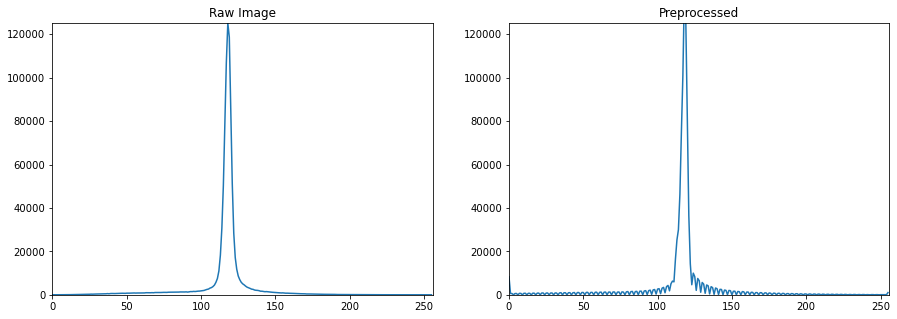

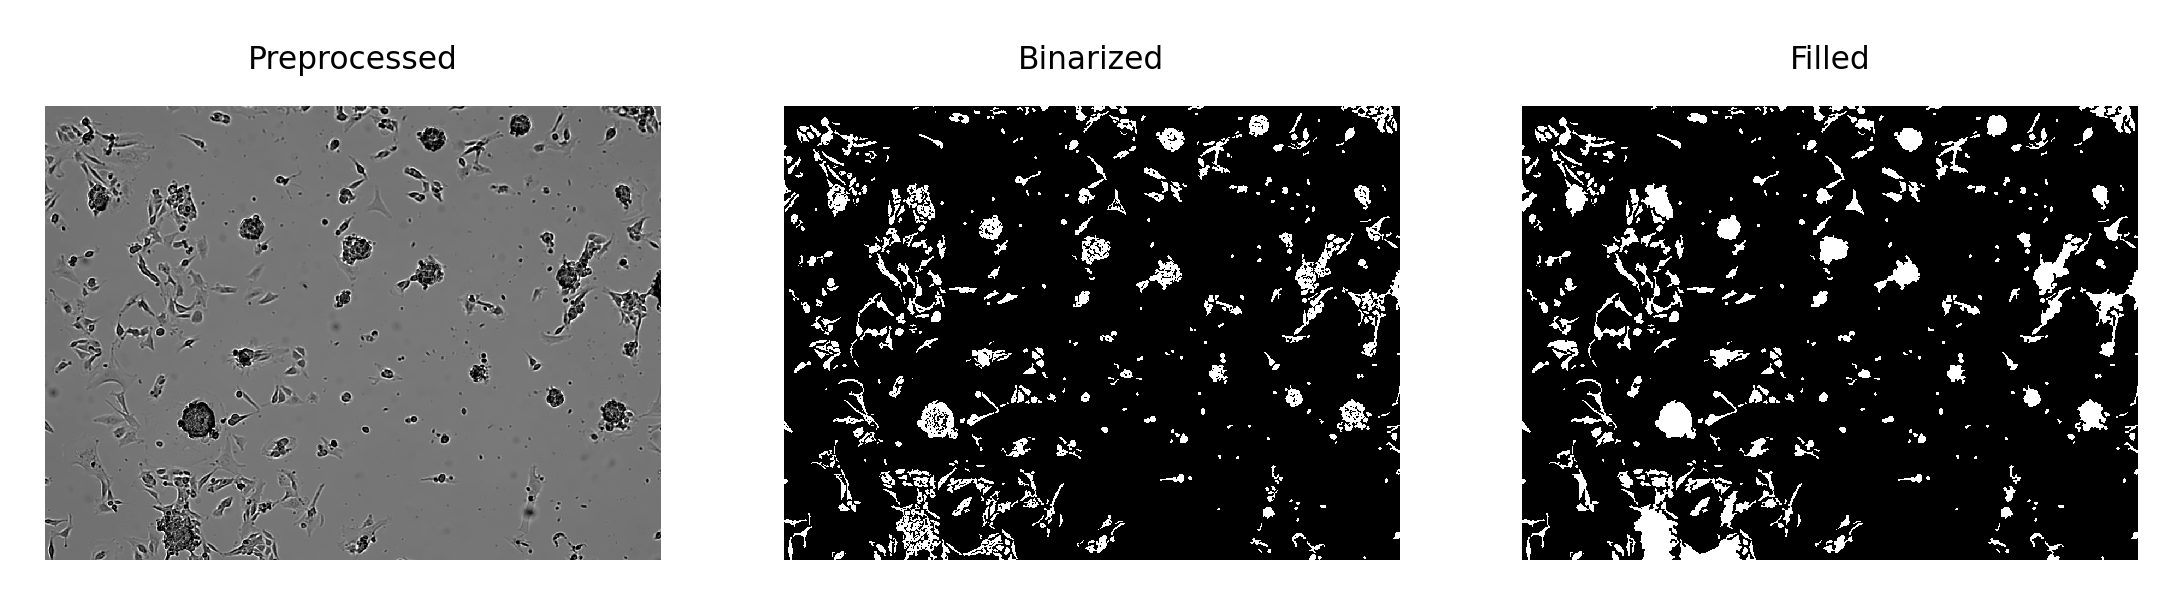

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x   y                                                                    
476 3                       0.640030                         15.430833   
541 14                      0.514036                         31.675234   
575 3                       0.403519                         25.020983   
621 7                       0.818371                         15.832663   
753 2                       0.201072                         32.367858   
...                              ...                               ...   
972 816                     0.725252                         40.999499   
177 811                     0.433917                         24.316580   
407 815                     0.581474                         15.038612   
169 824                     0.598243                         18.540161   
100 824                     0.517924                         21.726223   

        original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x   y                                                                   
476 3                               17.0                        105.5   
541 14                30.528675044947494                        335.5   
575 3                 25.495097567963924                        183.5   
621 7                  16.76305461424021                        153.5   
753 2                  30.59411708155671                        125.5   
...                                  ...                          ...   
972 816                42.20189569201838                        413.5   
177 811               26.076809620810597                        188.5   
407 815               15.033296378372908                         99.5   
169 824                             20.0                        146.5   
100 824               23.430749027719962                        187.5   

         original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x   y                                                                  
476 3                            9.876189          45.79898987322329   
541 14                          16.282211          89.59797974644671   
575 3                           10.096442           67.2132034355964   
621 7                           12.956994         52.041630560342576   
753 2                            6.508269           69.4558441227157   
...                                   ...                        ...   
972 816                         29.734969         183.78174593052051   
177 811                         10.551375          69.35533905932733   
407 815                          8.744561           41.2132034355964   
169 824                         11.091530          53.55634918610403   
100 824                         11.252533         59.455844122715675   

        original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
x   y                                                                           
476 3                       0.4341136480874246                          106.0   
541 14                     0.26705806183739705                          336.0   
575 3                       0.3662844873874463                          184.0   
621 7                         0.33903342384588                          154.0   
753 2                       0.5534330208981331                          126.0   
...                                        ...                            ...   
972 816                    0.44445404094442686                          414.0   
177 811                     0.3679328332059806                          189.0   
407 815                     0.4142030496039839                          100.0   
169 824                    0.36557234939320155                          147.0   
100 824                    0.31709783532115027                          188.0   

         original_shape2D_Sphericity original_firstorder_10Percentile  ...  \
x   y                      

In [5]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode, verbose=True)
df, masks = extract_features(raw_image, mask_image)
display(df)

## Scale features and reduce dimensions

In [6]:
scaler.fit(df.values)
pca.fit(df.values)

df = process_features(df)
display(df)

0             1            2           3           4   \
x   y                                                                      
476 3   -5.353585e+06 -12966.621312 -9374.245338 -398.969117 -117.020973   
541 14  -5.353585e+06 -12966.622247 -9374.219173 -398.922749 -117.228638   
575 3   -5.353585e+06 -12966.621375 -9374.248016 -398.967021 -116.963275   
621 7   -5.353585e+06 -12966.622569 -9374.283299 -398.938516 -117.250193   
753 2   -5.353585e+06 -12966.622292 -9374.280986 -398.927459 -117.161948   
...               ...           ...          ...         ...         ...   
972 816 -5.353585e+06 -12966.623653 -9374.301541 -398.927048 -117.734756   
177 811 -5.353585e+06 -12966.621844 -9374.262517 -398.941632 -117.041768   
407 815 -5.353585e+06 -12966.620543 -9374.241159 -398.981749 -116.713644   
169 824 -5.353585e+06 -12966.619812 -9374.197908 -399.049802 -116.772587   
100 824 -5.353585e+06 -12966.621743 -9374.219354 -398.946227 -117.084349   

                 5           6          7           8          9   ...  \
x   y                                                              ...   
476 3   -476.560654 -136.594515  72.492948  197.311004  16.029945  ...   
541 14  -475.386520 -136.585824  72.299484  195.853394  15.981173  ...   
575 3   -476.635463 -136.803119  72.418548  196.802902  16.065875  ...   
621 7   -475.647969 -136.398560  72.536277  197.328376  16.230046  ...   
753 2   -475.917114 -136.340988  72.483938  196.924971  16.299105  ...   
...             ...         ...        ...         ...        ...  ...   
972 816 -473.401679 -136.221579  72.361278  196.548218  17.398943  ...   
177 811 -476.384076 -136.701301  72.442842  196.753943  16.108357  ...   
407 815 -477.576347 -136.859050  72.390747  196.848576  15.502710  ...   
169 824 -477.308774 -136.989743  72.406306  197.228038  15.975610  ...   
100 824 -476.059106 -136.551134  72.412556  196.614303  15.918352  ...   

               87        88        89        90        91        92        93  \
x   y                                                                           
476 3    0.164807 -0.286425  0.304032 -0.760166 -1.239293  0.853608  0.032565   
541 14  -0.118665  0.539241 -0.231714 -0.959110 -0.909497 -0.465222  0.531635   
575 3    0.137675  0.093833  0.015085 -0.686375 -1.370418  0.425669  0.461108   
621 7   -0.092796  0.188753 -0.706203 -1.327878 -1.358242  0.129773 -0.255939   
753 2   -0.001423  0.043668 -0.250624 -0.820666 -1.074665  0.237745 -0.005074   
...           ...       ...       ...       ...       ...       ...       ...   
972 816 -0.712580 -0.328267 -1.257279 -1.603452 -0.639503  0.276736 -0.663889   
177 811 -0.037427 -0.198242 -0.296688 -0.931474 -1.504320  0.739013 -0.250839   
407 815  0.137889 -0.572522  0.340077 -0.348487 -1.516293  1.617157  0.655426   
169 824  0.203180 -0.680121  0.304629 -0.609485 -1.970440  2.027041 -0.481819   
100 824 -0.146644  0.255342 -0.151158 -1.055237 -1.021977  0.171481  0.016807   

               94        95        96  
x   y                                  
476 3   -0.053361  0.984005 -0.197319  
541 14  -0.013017  1.384539 -0.260887  
575 3   -0.135975  0.956666 -0.189431  
621 7   -0.092671  1.651750 -0.312889  
753 2    0.062400  1.298586 -0.250093  
...           ...       ...       ...  
972 816  0.285273  2.041949 -0.383073  
177 811 -0.109510  1.308787 -0.259056  
407 815 -0.191728  0.424567 -0.090616  
169 824 -0.170058  0.836238 -0.181393  
100 824  0.123501  1.404833 -0.268039  

[194 rows x 97 columns]

## Determine number of clusters

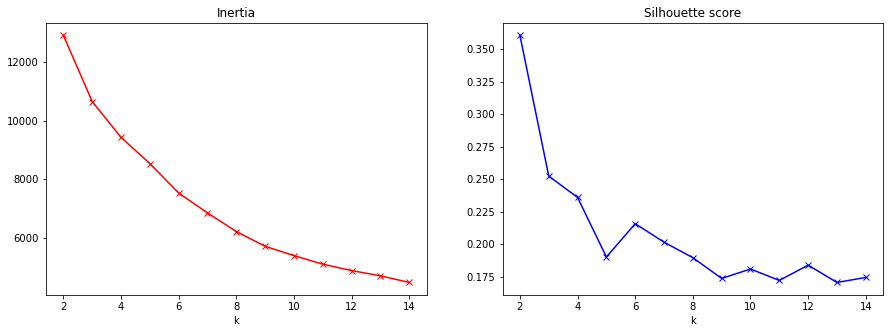

In [7]:
inertias = []
silhouette_scores = []
K = range(2, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(df)
    inertias += [kmeans.inertia_,]
    silhouette_scores += [silhouette_score(df, labels),]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(K, inertias, 'rx-')
ax1.set(xlabel='k', title="Inertia")
ax2.plot(K, silhouette_scores,'bx-')
ax2.set(xlabel='k', title="Silhouette score")
plt.show()

### User-defined values

In [8]:
# Manually select k based on visual inspection above
k = 4

# Classification colors (include k colors, or use colormap string)
colormap = matplotlib.colors.ListedColormap(['yellow', 'red', 'cyan', 'orange'])

## Fit and classify using silhouette score

In [9]:
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 42 (21.65%)
Class 1 (red): 46 (23.71%)
Class 2 (cyan): 12 (6.19%)
Class 3 (orange): 94 (48.45%)


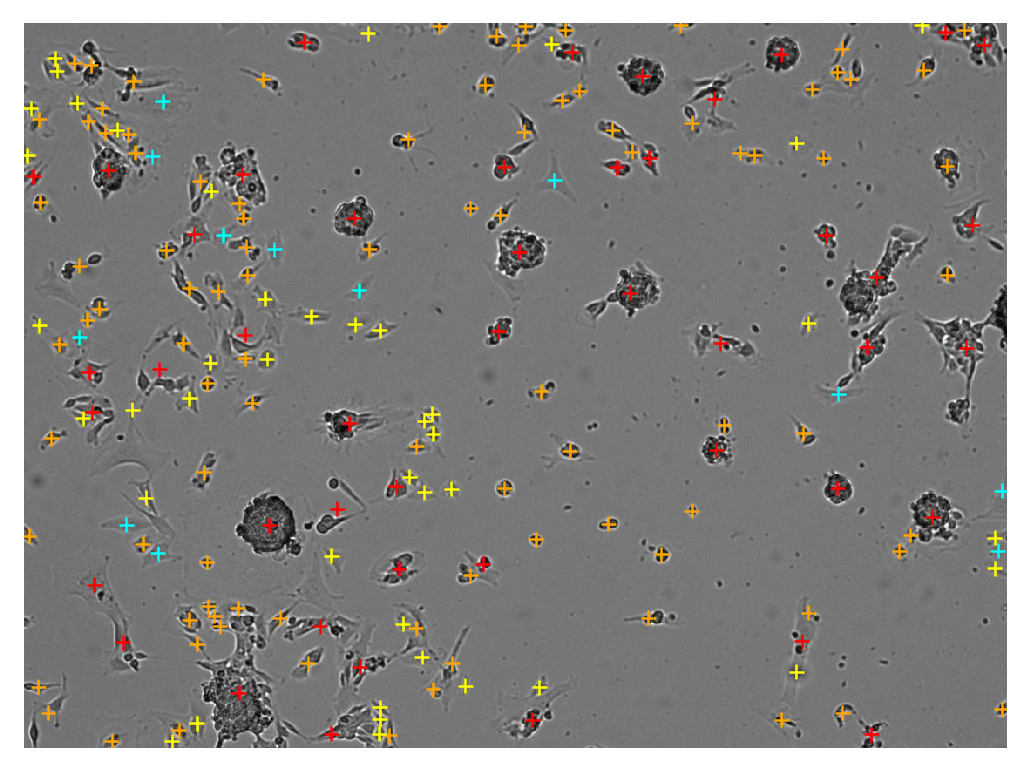

In [10]:
display_classifications(raw_image, df.index, labels)

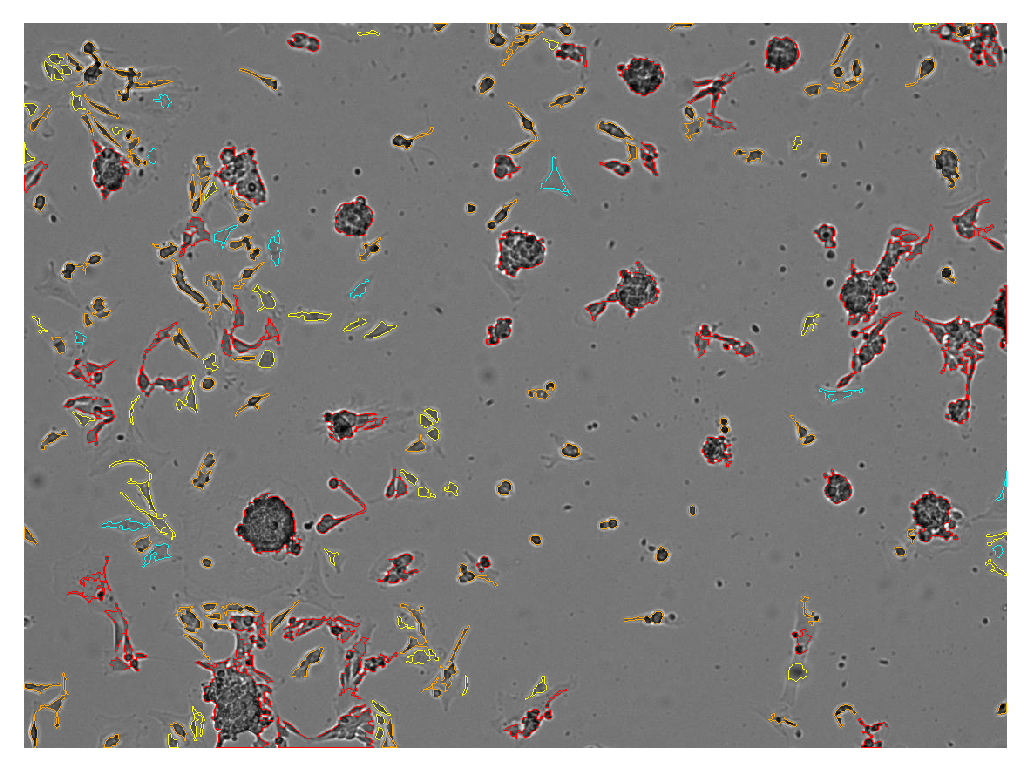

In [11]:
display_contours(raw_image, masks, labels)

Class 0, with 42 ROIs:


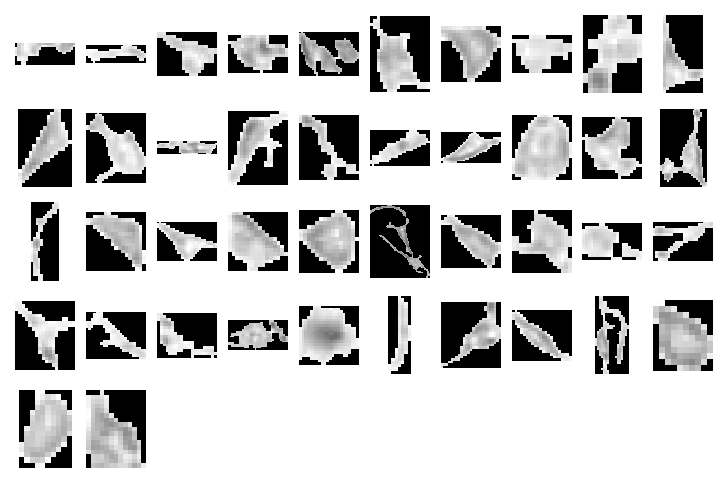

Class 1, with 46 ROIs:


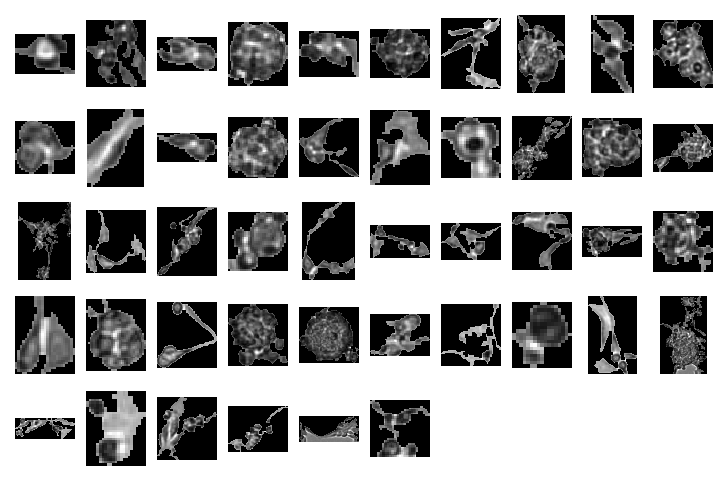

Class 2, with 12 ROIs:


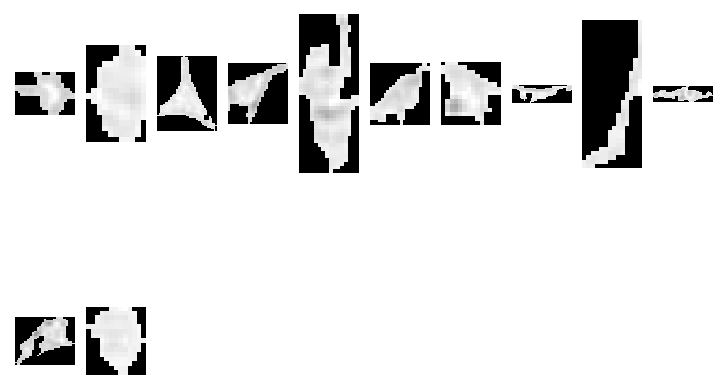

Class 3, with 94 ROIs:


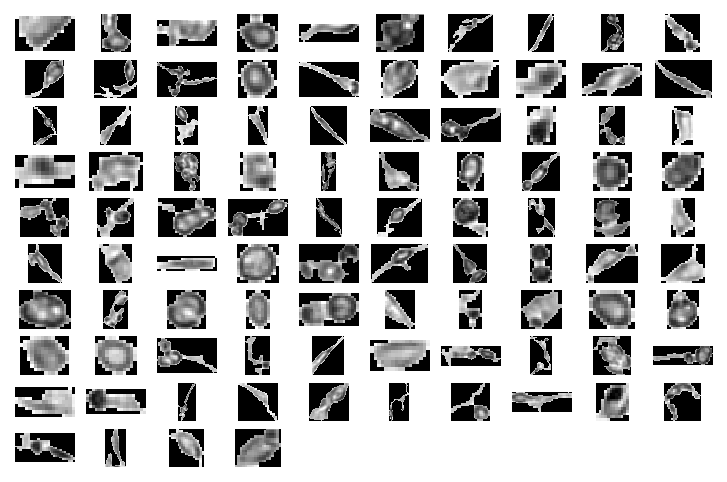

In [12]:
display_rois(raw_image, masks, labels)

## Cluster visualization

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


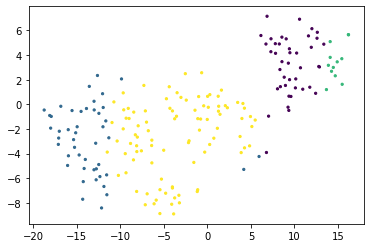

In [13]:
display_tsne(df)

# Classify cells on adherent image

In [14]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 44 (28.95%)
Class 1 (red): 40 (26.32%)
Class 2 (cyan): 12 (7.89%)
Class 3 (orange): 56 (36.84%)


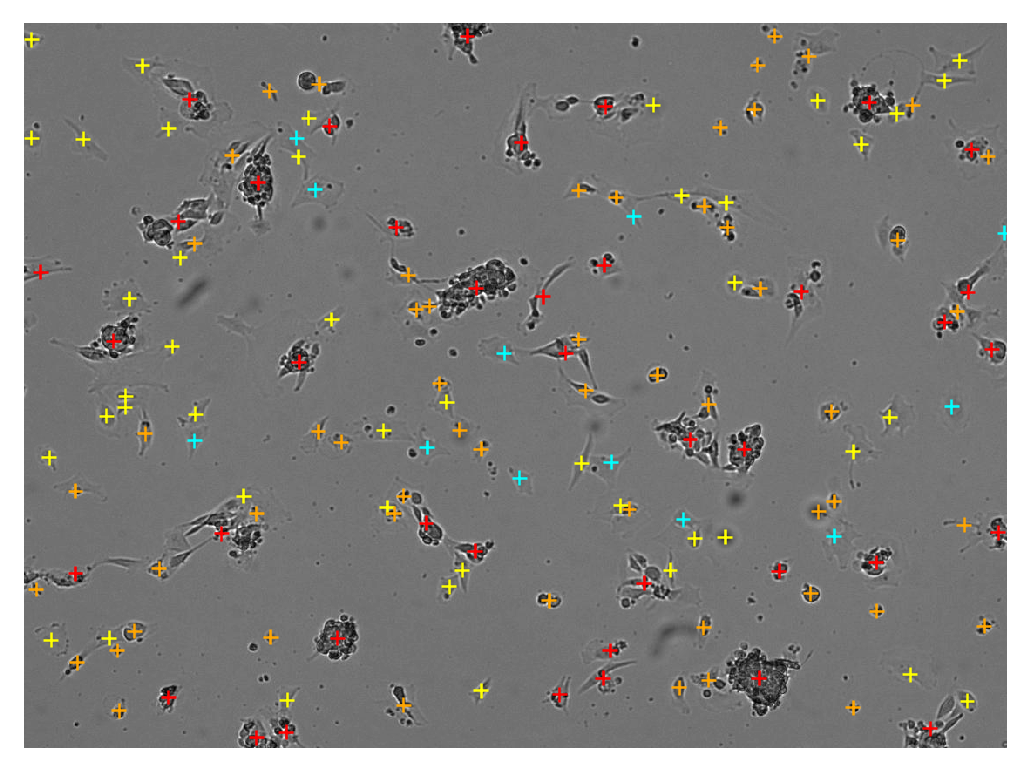

In [15]:
display_classifications(raw_image, df.index, labels)

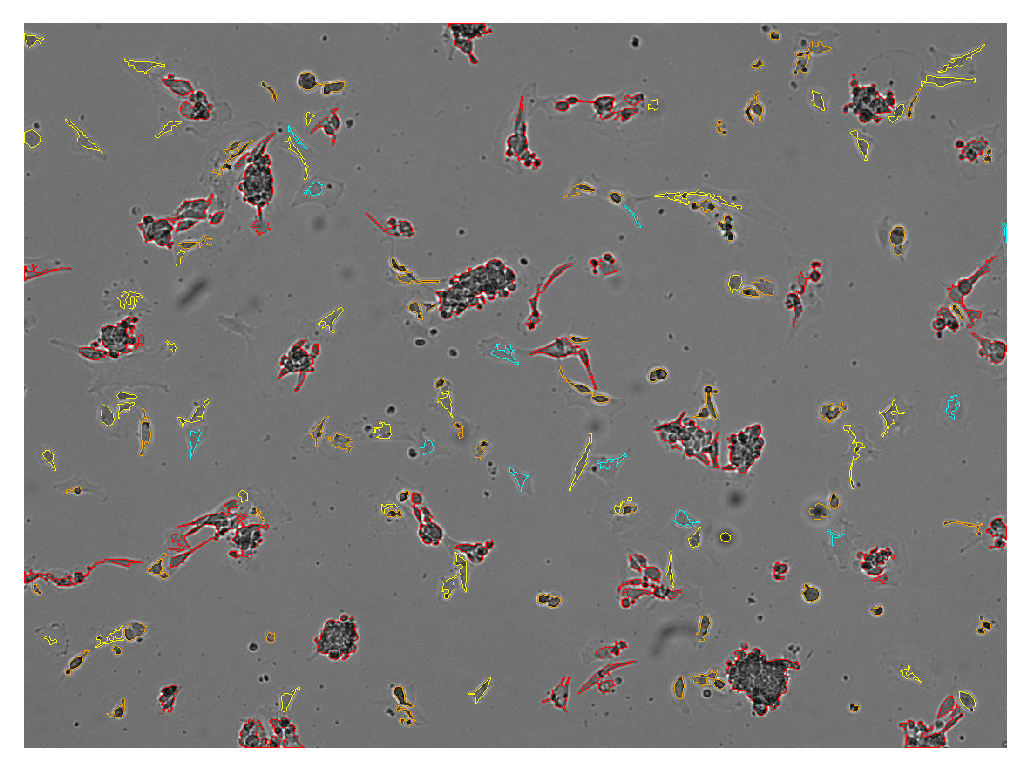

In [16]:
display_contours(raw_image, masks, labels)

Class 0, with 44 ROIs:


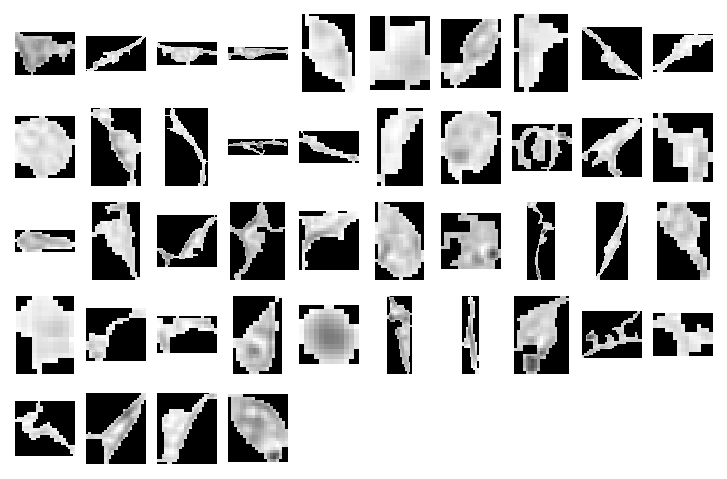

Class 1, with 40 ROIs:


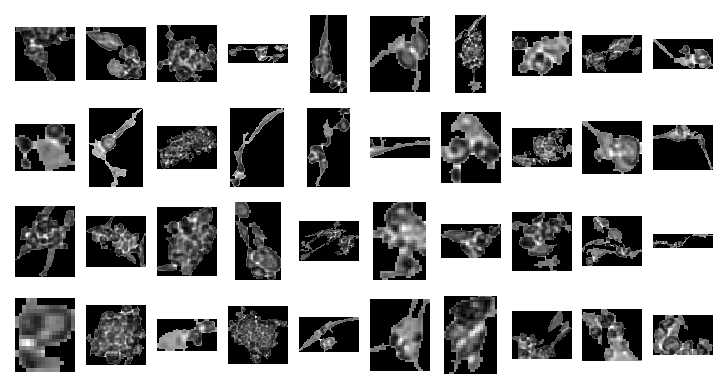

Class 2, with 12 ROIs:


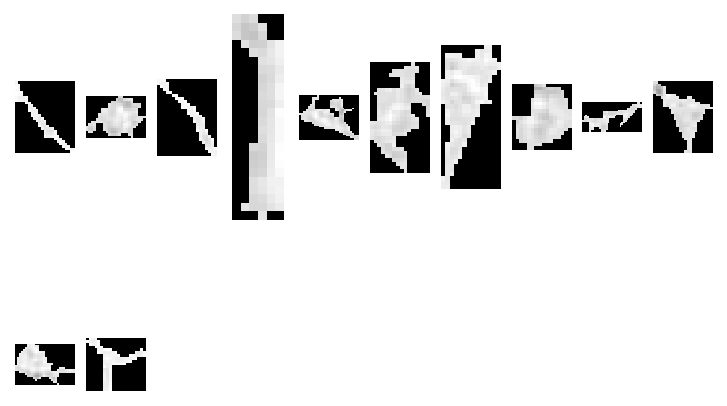

Class 3, with 56 ROIs:


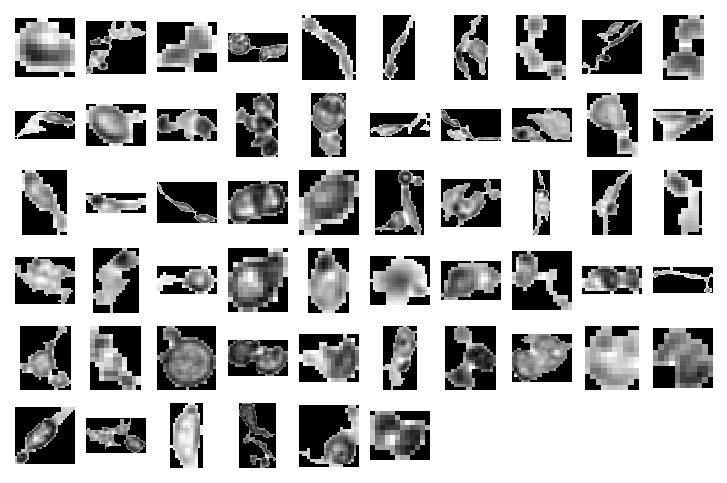

In [17]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


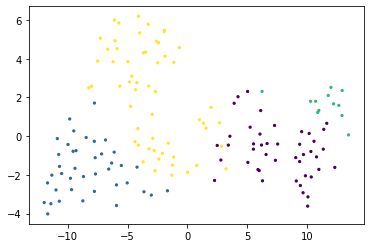

In [18]:
display_tsne(df)

# Classify cells on suspension image

In [19]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
mask_image = get_mask_image(raw_image, params, mode=mode)
df, masks = extract_features(raw_image, mask_image)
df = process_features(df)
labels = kmeans.predict(df)
print_classification_counts(labels)

Class 0 (yellow): 49 (32.03%)
Class 1 (red): 22 (14.38%)
Class 2 (cyan): 6 (3.92%)
Class 3 (orange): 76 (49.67%)


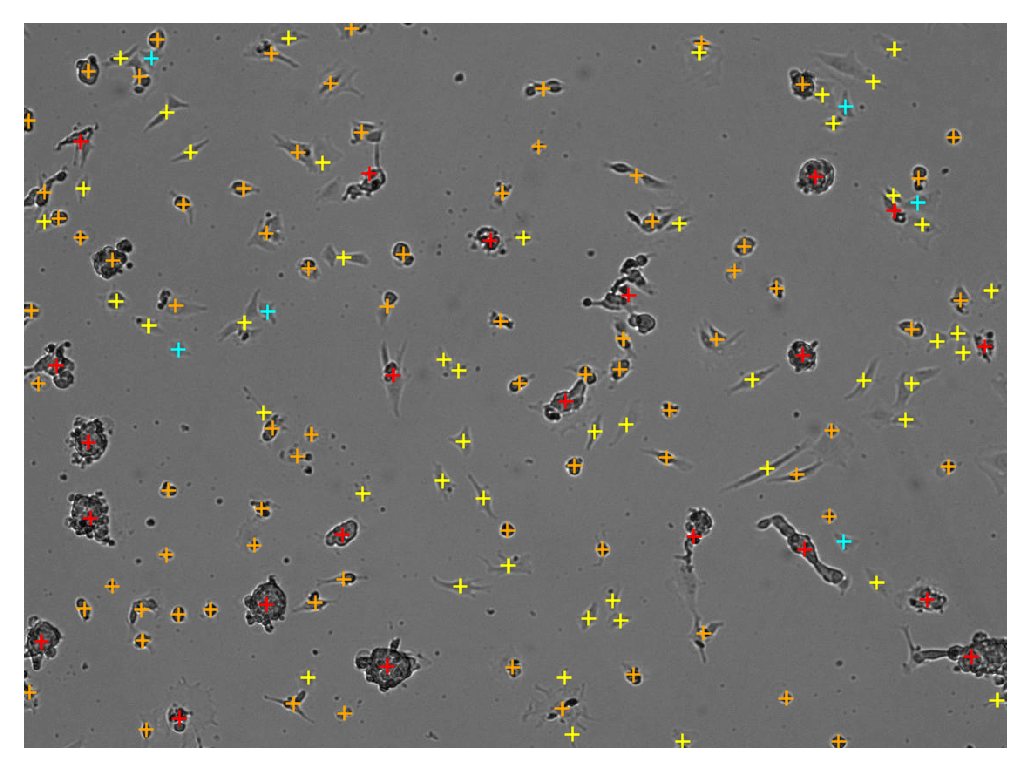

In [20]:
display_classifications(raw_image, df.index, labels)

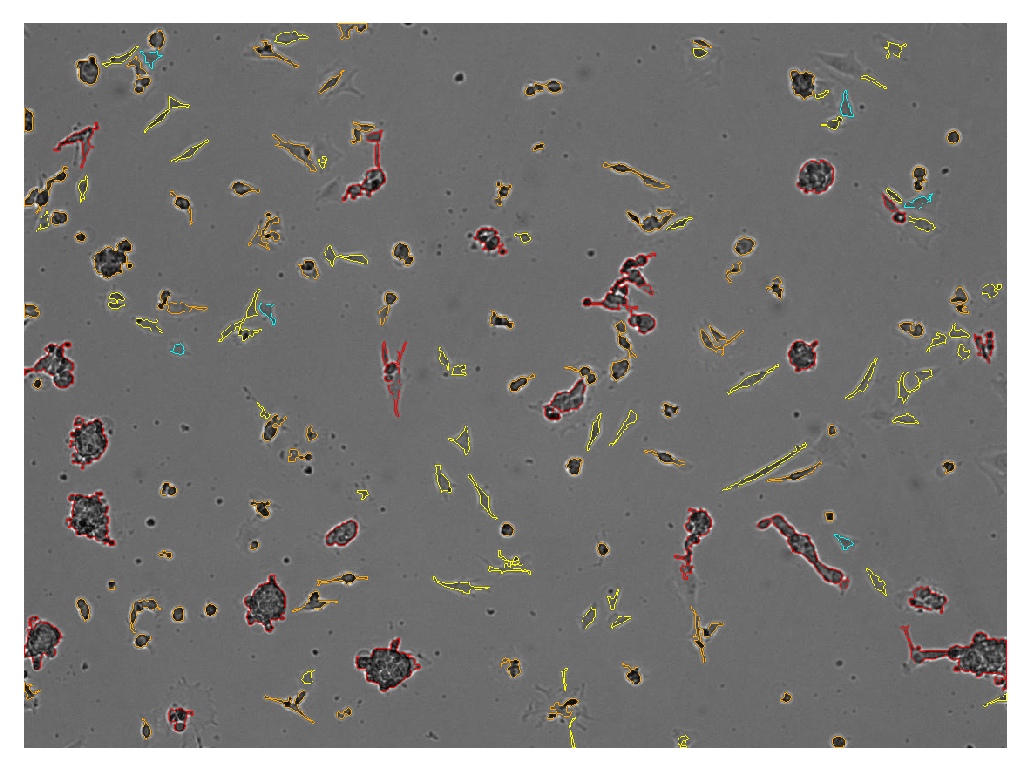

In [21]:
display_contours(raw_image, masks, labels)

Class 0, with 49 ROIs:


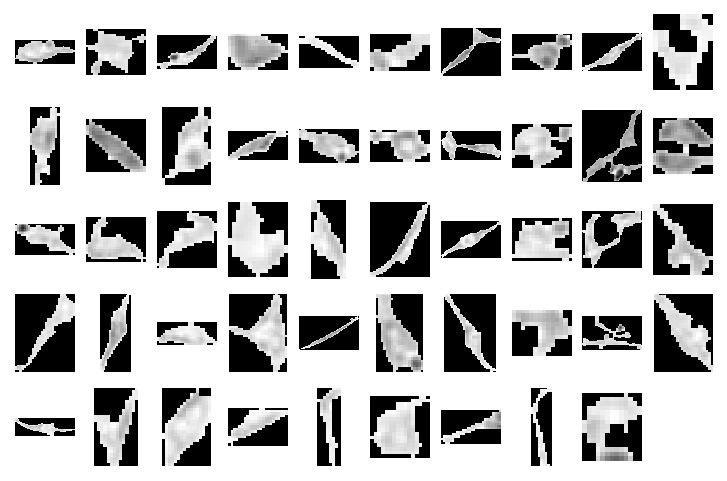

Class 1, with 22 ROIs:


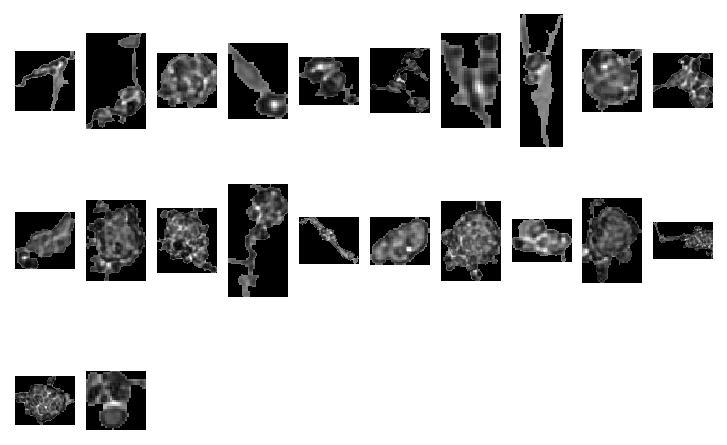

Class 2, with 6 ROIs:


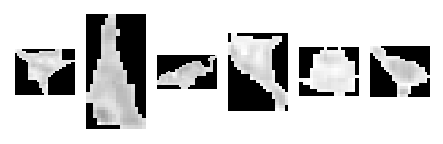

Class 3, with 76 ROIs:


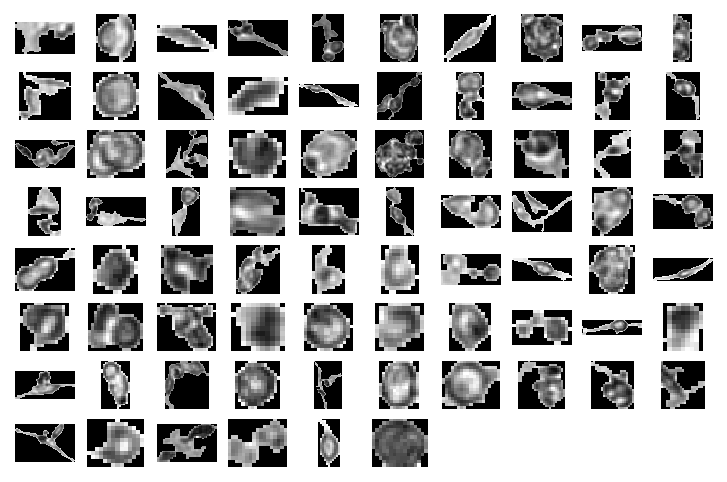

In [22]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


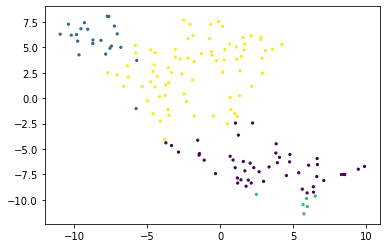

In [23]:
display_tsne(df)

# Experiment w/ multi-Otsu and Canny

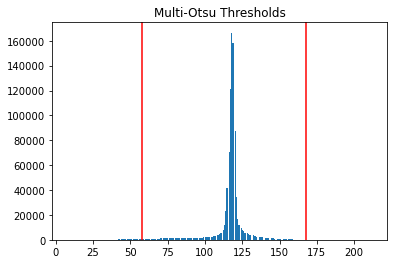

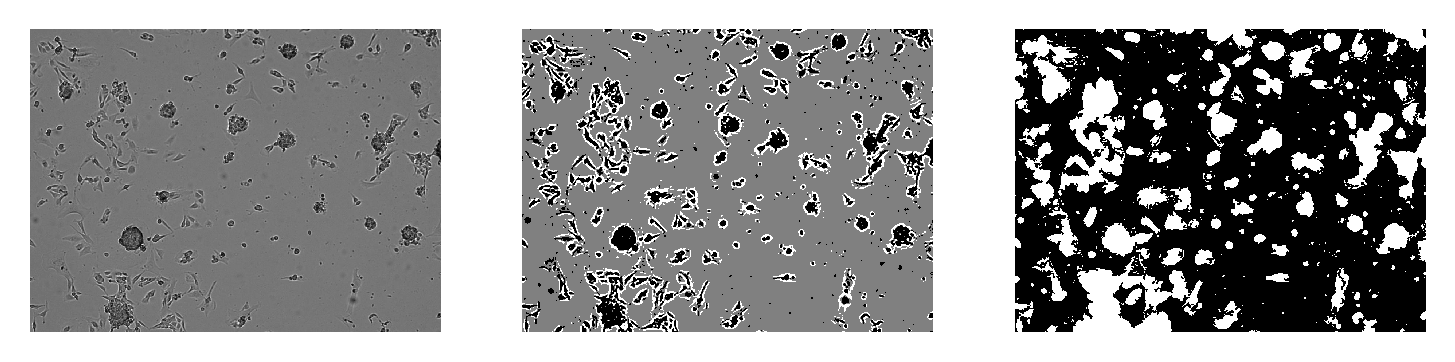

In [24]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
blurred = apply_blur(raw_image, 5)
enhanced = apply_contrast(blurred, 10)
thresholds = threshold_multiotsu(enhanced)
multi_otsu_regions = np.digitize(enhanced, bins=thresholds)
merged = np.uint8((multi_otsu_regions - 1) != 0)
filled = apply_imfill(apply_closure(merged, 3))

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, multi_otsu_regions, filled], columns=3, dpi=300)

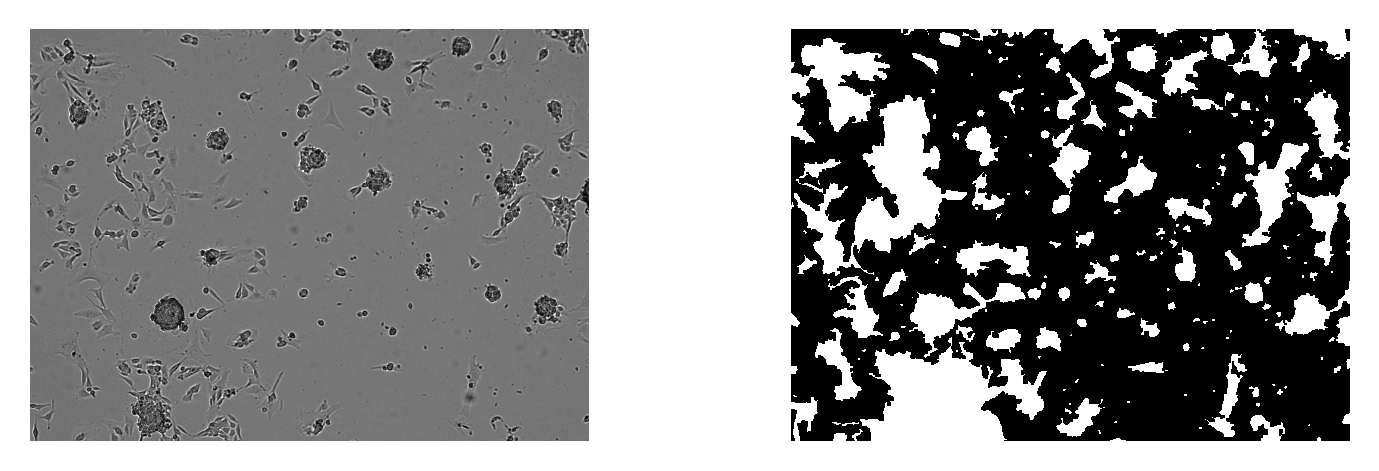

In [25]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
enhanced = apply_contrast(raw_image, 2)
canny = apply_canny(enhanced, 40, 180)
filled = apply_imfill(apply_closure(canny, 5))

display_image_array([raw_image, filled], columns=2, dpi=300)